<a href="https://colab.research.google.com/github/gyulab/gtee-bti-mlproject/blob/data-gen/BTI_data_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd

df = pd.read_csv(r'/content/drive/MyDrive/Colab_ML_ProfYu/csv_data/IV_BTI_base.csv', encoding='utf8')
t_stress_list = np.array([0, 1, 4, 7, 10, 40, 70, 100, 400, 700, 1000])
temp_list = np.array([273.15-15, 273.15+25, 273.15+85]) # Kelvin
#Vov_list = np.array([0.5, 1.0, 1.7])
Vgs_list = np.array(df.iloc[:, 0])[:22]
Vds_list=[0.01, 0.012, 0.015, 0.018, 0.022, 0.027, 0.034, 0.041, 0.050, 0.062, 0.075, 0.092, 0.113, 0.138, 0.169, 0.207, 0.253, 0.310, 0.379, 0.464, 0.568, 0.695, 0.851, 1.042, 1.275, 1.560, 1.9600, 2.337, 2.86, 3.4]

extend_num = len(t_stress_list)*len(temp_list)

print(df.shape)
df = df.iloc[:22, :60]
df.to_csv('/content/drive/MyDrive/Colab_ML_ProfYu/BTI_data_gen/IV_BTI_baseset.csv', index=False)
print(df.shape)

replicated_df = pd.concat([df] * extend_num, axis=1)
print(replicated_df.shape)
replicated_df.to_csv('/content/drive/MyDrive/Colab_ML_ProfYu/BTI_data_gen/extended_BTI_dataframe.csv', index=False)

(36, 240)
(22, 60)
(22, 1980)


In [16]:
from scipy import interpolate
#### detla Vth data ####

df = pd.read_excel(r'/content/drive/MyDrive/Colab_ML_ProfYu/BTI_data_gen/DG_BTI_Stress_P_N_H.xlsx')
PBTI_array = np.array(df.iloc[0:11, 1:10]) # 2D array (ts, temp)
NBTI_array = np.array(df.iloc[12:23, 1:10])
HCD_array = np.array(df.iloc[24:35, 1:10])

Vgs_neg = Vgs_list[:8] # For NBTI
Vgs_pos = Vgs_list[8:] # For PBTI, HCI

# PBTI
x_values = np.array([0.5, 1.0, 1.7])
PBTI_y_values = []
for i in range(len(t_stress_list)):
    temp_estimated_y_values = []
    for j in range(len(temp_list)):
        y_values = [PBTI_array[i,j], PBTI_array[i,3+j], PBTI_array[i,6+j]]
        linear_interpolation = interpolate.interp1d(x_values, y_values, kind='linear', fill_value='extrapolate')
        estimated_y_values = linear_interpolation(Vgs_pos)
        temp_estimated_y_values.append(estimated_y_values)
    PBTI_y_values.append(temp_estimated_y_values)
PBTI_y_values = np.array(PBTI_y_values) # 3D-array: (11,3,14) = (t_stress, temp, Vgs_pos)
print(PBTI_y_values.shape)

# NBTI
x_values_NBTI = np.array([-0.5, -1.0])
NBTI_y_values = []
for i in range(len(t_stress_list)):
    temp_estimated_y_values = []
    for j in range(len(temp_list)):
        y_values = [NBTI_array[i,j], NBTI_array[i,3+j]]
        linear_interpolation = interpolate.interp1d(x_values_NBTI, y_values, kind='linear', fill_value='extrapolate')
        estimated_y_values = linear_interpolation(Vgs_neg)
        temp_estimated_y_values.append(estimated_y_values)
    NBTI_y_values.append(temp_estimated_y_values)
NBTI_y_values = np.array(NBTI_y_values) # 3D-array: (11,3,8) = (t_stress, temp, Vgs_neg)

# HCD
HCD_y_values = []
for i in range(len(t_stress_list)):
    temp_estimated_y_values = []
    for j in range(len(temp_list)):
        y_values = [HCD_array[i,j], HCD_array[i,3+j], HCD_array[i,6+j]]
        linear_interpolation = interpolate.interp1d(x_values, y_values, kind='linear', fill_value='extrapolate')
        estimated_y_values = linear_interpolation(Vgs_pos)
        temp_estimated_y_values.append(estimated_y_values)
    HCD_y_values.append(temp_estimated_y_values)
HCD_y_values = np.array(HCD_y_values) # 3D-array: (11,3,14) = (t_stress, temp, Vgs_pos)

total_deltaV_variation = []
for i in range(len(t_stress_list)):
    temp_deltaV = []
    for j in range(len(temp_list)):
        test_y_values = np.concatenate((NBTI_y_values[i,j,:], PBTI_y_values[i,j,:])) # 85C 1000s BTI
        temp_deltaV.append(test_y_values)
    total_deltaV_variation.append(temp_deltaV)
total_deltaV_variation = np.array(total_deltaV_variation)

total_Vgs = []
for i in range(len(t_stress_list)):
    temp_Vgs = []
    for j in range(len(temp_list)):
        test_Vgs_values = Vgs_list - total_deltaV_variation[i,j,:]
        temp_Vgs.append(test_Vgs_values)
    total_Vgs.append(temp_Vgs)
total_Vgs = np.array(total_Vgs)
print(total_Vgs[10,2,:])

(11, 3, 14)
[-1.03       -0.89757143 -0.76514285 -0.63271428 -0.50028572 -0.36785715
 -0.23542857 -0.103       0.14644561  0.30368914  0.46093267  0.61817618
  0.77541971  0.93266324  1.08990677  1.2471503   1.40030542  1.54834992
  1.69639441  1.8444389   1.99248351  2.140528  ]


In [19]:
import numpy as np
from scipy import interpolate

def estimate_y_values(t_stress_list, temp_list, data_array, x_values, Vgs_values, concat = False):
    estimated_y_values = []
    for i in range(len(t_stress_list)):
        temp_estimated_y_values = []
        for j in range(len(temp_list)):
            # Determine the number of y_values based on the length of x_values
            num_y_values = len(x_values)
            y_indices = [j + k*len(temp_list) for k in range(num_y_values)]
            y_values = [data_array[i, idx] for idx in y_indices]
            # Linear interpolation
            linear_interpolation = interpolate.interp1d(x_values, y_values, kind='linear', fill_value='extrapolate')
            interpolated_values = linear_interpolation(Vgs_values)
            temp_estimated_y_values.append(interpolated_values)
        estimated_y_values.append(temp_estimated_y_values)
    return np.array(estimated_y_values)

x_values_PBTI = np.array([0.5, 1.0, 1.7])
x_values_NBTI = np.array([-0.5, -1.0])

PBTI_y_values = estimate_y_values(t_stress_list, temp_list, PBTI_array, x_values_PBTI, Vgs_pos)
NBTI_y_values = estimate_y_values(t_stress_list, temp_list, NBTI_array, x_values_NBTI, Vgs_neg)
HCD_y_values = estimate_y_values(t_stress_list, temp_list, HCD_array, x_values_PBTI, Vgs_pos)

print(PBTI_y_values.shape)

(11, 3, 14)


[[[ 0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.
    0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.
    0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.
    0.          0.          0.          0.        ]]

 [[-0.00107635 -0.00133816 -0.00159998 -0.00186179 -0.00212361
   -0.00238542 -0.00264723 -0.00290905 -0.00378638 -0.0054331
   -0.00707983 -0.00872655 -0.01037328 -0.01202   ]
  [-0.00245482 -0.00305194 -0.00364906 -0.00424618 -0.0048433
   -0.00544042 -0.00603754 -0.00663466 -0.00960855 -0.0155534
   -0.02149825 -0.0274431  -0.03338795 -0.0393328 ]
  [-0.01877693 -0.0233443  -0.02791166 -0.03247902 -0.03704638
   -0.04161374 -0.04618111 -0.05074847 -0.05547447 -0.06039878
   -0.06532308 -0.07024739 -0.075

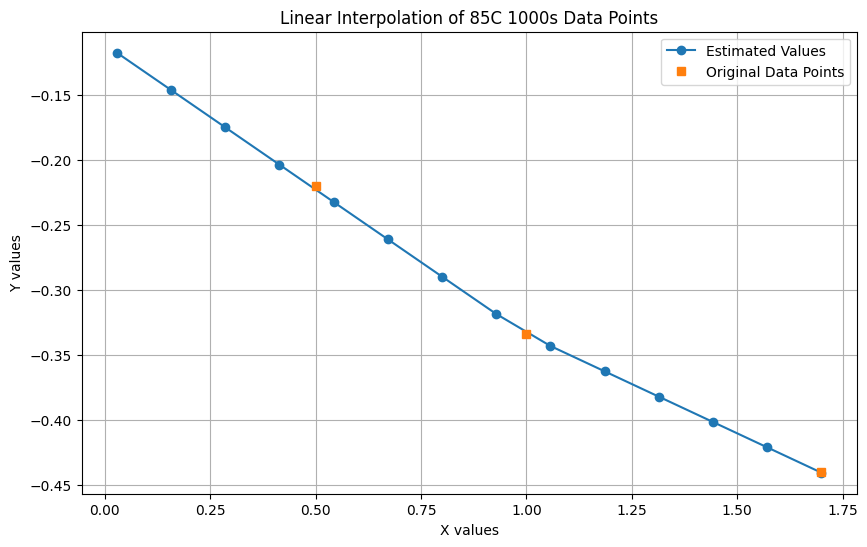

In [21]:
import matplotlib.pyplot as plt
test_y_values = PBTI_y_values[10,2,:] # 85C 1000s PBTI
print(PBTI_y_values)
plt.figure(figsize=(10, 6))
plt.plot(Vgs_pos, test_y_values, 'o-', label='Estimated Values')
plt.plot(x_values, [-0.22, -0.334, -0.44], 's', label='Original Data Points')
plt.title('Linear Interpolation of 85C 1000s Data Points')
plt.xlabel('X values')
plt.ylabel('Y values')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#t = np.arange(0, 1001, 100)  # Time from 0 to 1000 by intervals of 100s]
#delta_Vg_m15_ = [0, 0, 0, 0, 0, 0, 0.00259844729997958, -0.000457053125252409, -0.0103, -0.0197, -0.0307, ]
#delta_Vg_25
delta_Vg_85 = PBTI_y_values[10,2,:]
# Subtract delta_Vg from Vg_test for each time step
#Vg_modified_m15 = np.array([Vg_test + delta for delta in delta_Vg_m15])
#print(Vg_modified_m15)
#Vg_modified_25 = np.array([Vg_test + delta for delta in delta_Vg_25])
Vg_modified_85 = np.array([Vgs_list + delta for delta in delta_Vg_85])
Vg_modified_vstack = np.vstack((Vg_modified_m15, Vg_modified_25, Vg_modified_85))
Id0_test = np.array(idvg_temp.iloc[:, 243])
print("Id0_test: {}".format(Vg_modified_vstack))
plt.plot(Vg_test, (Id0_test), label = "Original") ## TCAD
for i in range(11):
    plt.plot(Vg_modified_85[i][:], Id0_test, label = "85C PBTI at t={}".format(i*100)) ## TCAD
    #plt.plot(Vg_modified_85[i][:], Id85_test, label = "85C PBTI") ## TCAD
#plt.scatter(Vg_test, np.log10(Id2_test), label = "VD = 2.4V") ## TCAD
#plt.plot(vd_temp, np.log10(Id0_test), label = "VD = 0.05V")
#plt.plot(vd_temp, np.log10(Id_test), label = "VD = 1V")
#plt.plot(vd_temp, np.log10(Id2_test), label = "VD = 2.4V")
plt.xlabel("Gate Voltage [V]")
plt.ylabel("Current [A/um]")
plt.legend()
plt.show()
